In [1]:
%%capture
!pip install prophet
!pip install stan
!pip install pystan
!pip install nest_asyncio

In [12]:
import pandas as pd
from prophet import Prophet
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import stan
import nest_asyncio
nest_asyncio.apply()


# DATA

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/business_is_business/main/England_covid.csv')
df.head()


,date,area_type,area_name,daily_cases,cum_cases,new_deaths_28days,cum_deaths_28days,new_deaths_60days,cum_deaths_60days,new_first_episode,...,new_third_dose,cum_third_dose,new_admissions,cum_admissions,hospital_cases,ventilator_beds,trans_rate_min,trans_rate_max,trans_growth_min,trans_growth_max
0,2023-02-01,nation,England,1573.0,20535061.0,NaN,NaN,NaN,NaN,892.0,...,625.0,33356701.0,NaN,NaN,6055.0,136.0,NaN,NaN,NaN,NaN
1,2023-01-31,nation,England,2678.0,20533488.0,NaN,NaN,NaN,NaN,1564.0,...,587.0,33356076.0,NaN,NaN,6015.0,136.0,NaN,NaN,NaN,NaN
2,2023-01-30,nation,England,2886.0,20530810.0,30.0,180801.0,41.0,226052.0,1724.0,...,613.0,33355489.0,741.0,958745.0,5959.0,142.0,NaN,NaN,NaN,NaN
3,2023-01-29,nation,England,2118.0,20527924.0,44.0,180771.0,72.0,226011.0,1224.0,...,247.0,33354876.0,705.0,958004.0,5834.0,145.0,NaN,NaN,NaN,NaN
4,2023-01-28,nation,England,1711.0,20525806.0,47.0,180727.0,80.0,225939.0,1119.0,...,1326.0,33354629.0,562.0,957299.0,5750.0,140.0,NaN,NaN,NaN,NaN


In [4]:
#Nettoyage des données
df = df[["date", "new_deaths_60days","new_virus_test","daily_cases"]]
df.head()

,date,new_deaths_60days,new_virus_test,daily_cases
0,2023-02-01,NaN,20351,1573.0
1,2023-01-31,NaN,22623,2678.0
2,2023-01-30,41.0,24780,2886.0
3,2023-01-29,72.0,23254,2118.0
4,2023-01-28,80.0,24243,1711.0


In [5]:
missing = df.isnull().sum()
print(missing)
print(df.size)

#On décide d'enlever les valeurs manquantes
df = df.dropna(axis=0)
df.head()

date                  0
new_deaths_60days    61
new_virus_test        0
daily_cases          27
dtype: int64
4504


,date,new_deaths_60days,new_virus_test,daily_cases
2,2023-01-30,41.0,24780,2886.0
3,2023-01-29,72.0,23254,2118.0
4,2023-01-28,80.0,24243,1711.0
5,2023-01-27,97.0,31287,2189.0
6,2023-01-26,119.0,37446,2250.0


In [6]:
#On transforme la date en donnée incrémentale 
df = df.sort_values(by='date')
df['j'] = np.arange(df.shape[0])
df["j"] = df['j'] + 1
df.tail()

,date,new_deaths_60days,new_virus_test,daily_cases,j
6,2023-01-26,119.0,37446,2250.0,1061
5,2023-01-27,97.0,31287,2189.0,1062
4,2023-01-28,80.0,24243,1711.0,1063
3,2023-01-29,72.0,23254,2118.0,1064
2,2023-01-30,41.0,24780,2886.0,1065


# Construction de la matrice design

In [7]:
#fonction pour implémenter la matrice design à partir de j (voir mémoire pour la méthodologie). Elle prend un j et retourne le vecteur associé. 
def find_var_expl_time(j): 
    x_j = [1]
    x_j.append(j/365*3)
    for l in range(2,46): 
        if l >= 2 and l <= 8: 
            x_j.append(math.cos(2*math.pi*(l-2)*j/7))
        elif l >= 9 and l <= 15:
            x_j.append(math.sin(2*math.pi*(l-9)*j/7))
        elif l >= 16 and l <= 30: 
            x_j.append(math.cos(2*math.pi*(l-16)*j/(365.25)))
        elif l >= 31 and l <= 45:
            x_j.append(math.sin(2*math.pi*(l-35)*j/(365.25)))
    return x_j

In [8]:
#Construction de la matrice design à partir de la fonction précèdente. 
mat_design = np.empty((0,46))
for j in df["j"]:
    row = np.array(find_var_expl_time(j))
    mat_design = np.r_[mat_design,[row]]

#mat_design = pd.DataFrame(mat_design)

In [9]:
mat_design

array([[1.00000000e+00, 8.21917808e-03, 1.00000000e+00, ...,
        1.37185404e-01, 1.54204048e-01, 1.71177060e-01],
       [1.00000000e+00, 1.64383562e-02, 1.00000000e+00, ...,
        2.71776738e-01, 3.04719233e-01, 3.37301069e-01],
       [1.00000000e+00, 2.46575342e-02, 1.00000000e+00, ...,
        4.01228985e-01, 4.47944939e-01, 4.93468142e-01],
       ...,
       [1.00000000e+00, 8.73698630e+00, 1.00000000e+00, ...,
        9.78988874e-01, 9.36590583e-01, 6.04701877e-01],
       [1.00000000e+00, 8.74520548e+00, 1.00000000e+00, ...,
        9.41758934e-01, 9.79425086e-01, 7.32110943e-01],
       [1.00000000e+00, 8.75342466e+00, 1.00000000e+00, ...,
        8.86721063e-01, 9.98829828e-01, 8.37908509e-01]])

# Régression linéaire 

In [15]:
#Regression linéaire simple:
X = mat_design
y = df["new_virus_test"]
model = LinearRegression().fit(X, y)

epsilon = model.intercept_
theta = model.coef_

print("Intercept : ",epsilon)
print("Beta : ", theta)

Intercept :  10653972756292.0
Beta :  [-8.85566644e+12  6.79418912e+03  8.85743826e+13  1.27595079e+16
  2.25085571e+16 -4.62591842e+16  4.62591842e+16 -2.25085571e+16
 -1.27595079e+16 -9.20475328e+12  7.00782807e+15  2.43997969e+16
  2.31460230e+16  2.31460230e+16  2.43997969e+16  7.00782807e+15
 -9.03726884e+13  1.21475213e+05  4.86454039e+04  3.46248381e+03
 -1.68945236e+04  7.72904117e+03  1.01306003e+04 -2.85857635e+04
 -2.38232582e+04 -3.09641476e+04 -2.21029870e+04 -1.83837049e+04
 -1.45739898e+04  2.50410068e+03  1.51934173e+04 -2.71537982e+13
 -4.19105551e+12  1.67566383e+13 -3.76213996e+13 -8.95119615e+11
 -3.76213996e+13  1.67566382e+13 -4.19105553e+12 -2.71537981e+13
 -1.41123458e+04  7.82408637e+03 -4.83270472e+03  6.09632585e+03
  6.25603083e+03  1.30033945e+04]


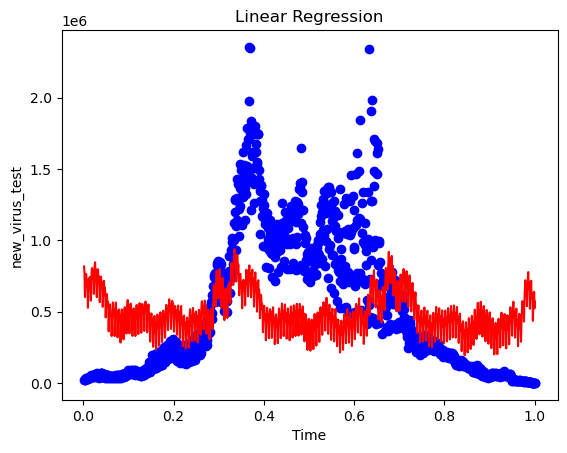

In [13]:
T = df.shape[0]
t = np.array(df.index).reshape(-1, 1) / T


plt.scatter(t, df['new_virus_test'], color='blue')
plt.plot(t, model.predict(X), color='red')
plt.xlabel('Time')
plt.ylabel('new_virus_test')
plt.title('Linear Regression')
plt.show()

In [19]:
#Regression bayésienne avec stan
stan_code = """
data {
    int<lower=0> N;
    int<lower=0> P;
    matrix[N, P] X;
    vector[N] y;
}
parameters {
    vector[P] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(X * beta, sigma);
    sigma ~ normal(0, 0.5);
}
"""

# Data
N = X.shape[0]
P = X.shape[1]
stan_data = {'N': N, 'P': P, 'X': pd.DataFrame(X).values, 'y': df["new_virus_test"].values}
posterior = stan.build(stan_code, data=stan_data, random_seed = 1)
fit = posterior.sample(num_chains = 4, num_samples = 1000)

df_fit = fit.to_frame()

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampli

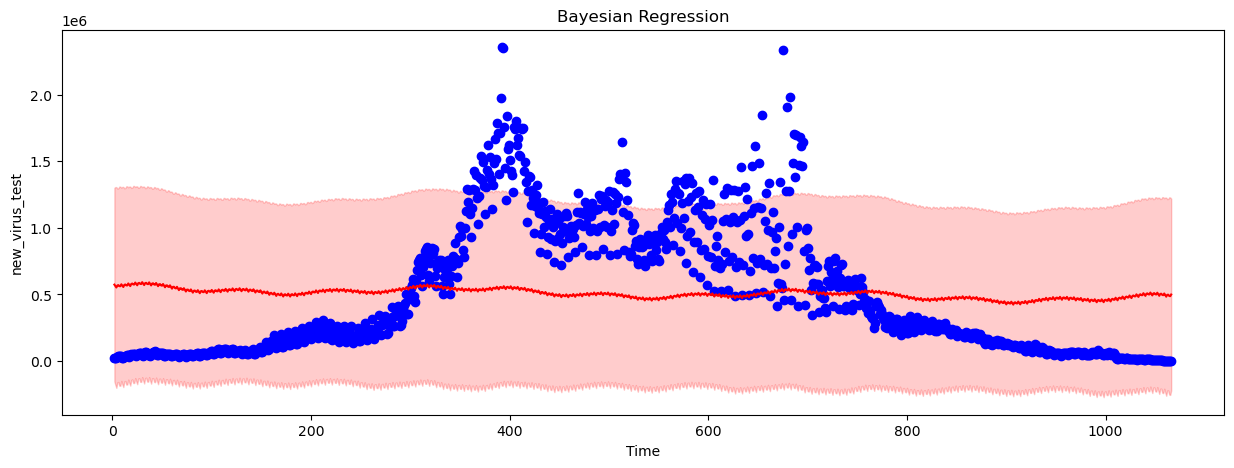

In [23]:
df_fit.head()
# Extract the posterior samples
posterior_samples = df_fit[['beta.1', 'beta.2', 'beta.3', 'beta.4', 'beta.5', 'beta.6', 'beta.7', 'beta.8', 'beta.9', 'beta.10', 'beta.11',       'beta.12', 'beta.13', 'beta.14', 'beta.15', 'beta.16', 'beta.17',       'beta.18', 'beta.19', 'beta.20', 'beta.21', 'beta.22', 'beta.23',       'beta.24', 'beta.25', 'beta.26', 'beta.27', 'beta.28', 'beta.29',       'beta.30', 'beta.31', 'beta.32', 'beta.33', 'beta.34', 'beta.35',       'beta.36', 'beta.37', 'beta.38', 'beta.39', 'beta.40', 'beta.41',       'beta.42', 'beta.43', 'beta.44', 'beta.45', 'beta.46']]

# Compute the posterior predictive distribution
y_pred = X.dot(posterior_samples.mean().values)
y_pred_std = X.dot(posterior_samples.std().values)

# Plot the posterior predictive distribution
plt.figure(figsize=(15, 5))
plt.plot(df.index, y_pred, color='red')
plt.fill_between(df.index, y_pred - y_pred_std, y_pred + y_pred_std, color='red', alpha=0.2)
plt.scatter(df.index, df['new_virus_test'], color='blue')
plt.xlabel('Time')
plt.ylabel('new_virus_test')
plt.title('Bayesian Regression')
plt.show()

# Régression 1 du Modèle 1 

In [1]:
Model = """
data {
  int N; //nombre de données 
  int y[N]; //nombre de tests Covid
  int K; // nombre de colonnes de la matrice design
  matrix[N, K] X; //matrice design 
  vector[K] theta; //theta (voir mémoire Rég 1) correspondant au beta de la régression précèdente 
  // priors
  real reciprocal_sigma_scale; // borne sup de la loi normale que suit l'inverse du sigma (voir mémoire) 
}
parameters {
  real reciprocal_sigma; //inverse du sigma
}
transformed parameters {
  vector[N] mu;
  real sigma; //
  mu = exp(X * theta);
  sigma = 1. / reciprocal_sigma;
}
model {
  reciprocal_sigma ~ normal(0., reciprocal_sigma_scale);
  y ~ neg_binomial_2_log(mu, sigma);
}
generated quantities {
  vector[N] y_rep;
  for (i in 1:N) {
    y_rep[i] = neg_binomial_2_rng(mu[i], sigma);
  }
}
"""

In [31]:
len(theta)

46

In [20]:
%%capture
Data = {"y": list(df["new_virus_test"]),
                "N": len(y),
                "X": mat_design,
                "K" : mat_design.shape[1],
                "theta" : theta,
                "reciprocal_sigma_scale" : 0.5
       }


posterior = stan.build(Model, data=Data)
fit = posterior.sample(num_chains=4, num_samples=1000)
df2 = fit.to_frame()  # pandas `DataFrame`

Building...

In file included from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/onyxia/.cache/httpstan/4.9.1/models/v47afgoa/model_v47afgoa.cpp:2:
/opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c


Building: 16.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_rusmeyy8/model_v47afgoa.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.


RuntimeError: Error calling get_param_names: `Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=theta; dims declared=(46); dims found=(46,4000) (in '/tmp/httpstan_sjhob61_/model_v47afgoa.stan', line 7, column 2 to column 18)`

In [ ]:
print(fit)

In [21]:
beta

array([[ 5.26091583e+07, -1.01716631e+07,  5.38971421e+07, ...,
        -6.05182041e+07,  2.15345837e+08, -7.04405137e+07],
       [-9.25278179e+03,  1.50775887e+04,  8.59727991e+03, ...,
         4.37327144e+03,  1.28085904e+04,  1.22705830e+04],
       [-1.36559318e+07,  9.54572746e+06,  2.10485088e+07, ...,
         1.80489983e+08, -5.04055901e+07,  3.14713610e+07],
       ...,
       [-3.04185088e+04,  1.52683682e+04,  2.92309178e+04, ...,
         1.35634643e+04,  2.57852315e+04, -2.18393015e+04],
       [-1.51591600e+04,  8.98459535e+03,  2.55630151e+04, ...,
        -1.43579174e+04, -1.88370444e+04, -1.63623767e+04],
       [ 1.73866282e+04, -1.37595081e+04, -1.70250924e+04, ...,
         7.72183099e+03, -2.32435038e+04,  1.82633274e+04]])